In [2]:
import os,sys
import math

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sys.path.append("../../src")  # adjust path as needed
from read_Parkinsonpredict import ReadData, LoadData
from ml_models import MlModels

### 🧬 Load the Merged Gene Expression & MRI Data 🧠

In [3]:
path = '/Users/pushpita/Documents/Erdos_bootcamp/our_project/Data/fomatted_data/Updated/with_clinical_data/'
loaddata = LoadData(input_path=path+'merged_all_50.csv')
X_train, Y_train = loaddata.merged_data()
X_train_cleanmri = X_train.drop(columns=["lh_MeanThickness", "lh_WhiteSurfArea", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"])
X_train_cleanmri["GENDER"] = X_train_cleanmri["GENDER"].map({"Female": 1, "Male": 0})

mask = X_train_cleanmri["AGE"].notna()
X_train_new = X_train_cleanmri[mask]
Y_train_new = Y_train[mask]


Is PATNO sorted?: True
Do we have all unique patients?: Yes
The train and test data is split according to 80.0 - 20.0%
The data is further grouped in 0 (Control), 1 (NHY = 1 and 2) and 2 (NHY > 2)


#### 🧠 Feel the data — see it, sense it, *understand* it!

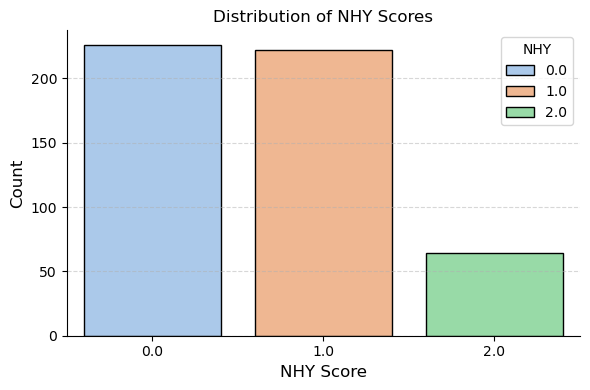

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x='NHY', data=Y_train, hue='NHY', palette='pastel', edgecolor='black')
plt.title("Distribution of NHY Scores", fontsize=12)
plt.xlabel("NHY Score", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

In [6]:
X_train_new.columns

Index(['rh_MeanThickness', 'rh_WhiteSurfArea', 'Left_Cerebellum_White_Matter',
       'Right_Cerebellum_White_Matter', 'CerebralWhiteMatterVol',
       'rhSurfaceHoles', 'lhSurfaceHoles', 'GENDER', 'AGE', 'EDUC_YRS',
       'ENSG00000178726', 'ENSG00000089195', 'ENSG00000167207',
       'ENSG00000211792', 'ENSG00000136122', 'ENSG00000088986',
       'ENSG00000198015', 'ENSG00000110203', 'ENSG00000169519',
       'ENSG00000147138', 'ENSG00000052802', 'ENSG00000237541',
       'ENSG00000198919', 'ENSG00000214736', 'ENSG00000203747',
       'ENSG00000165929', 'ENSG00000102317', 'ENSG00000164167',
       'ENSG00000113597', 'ENSG00000234745', 'ENSG00000128654',
       'ENSG00000169490', 'ENSG00000105810', 'ENSG00000282826',
       'ENSG00000187837', 'ENSG00000256262', 'ENSG00000082898',
       'ENSG00000049167', 'ENSG00000115875', 'ENSG00000047597',
       'ENSG00000164338', 'ENSG00000176124', 'ENSG00000135218',
       'ENSG00000211812', 'ENSG00000205045', 'ENSG00000092758',
       'ENSG000

In [7]:
print(X_train.shape, X_train_new.shape)

(512, 64) (511, 60)


Splitting the trainning data further into train and validation set

In [9]:
X_train_reg, X_cv, Y_train_reg, Y_cv = train_test_split(X_train_new, Y_train_new, test_size=0.1, shuffle=True)
data = {}
data['X_train'] = X_train_reg
data['Y_train'] = Y_train_reg

In [10]:
params_xgb = {'max_depth':6}
my_model_boost = MlModels(model_name = 'xgboost', data=data, params = params_xgb, pca_flag=False)
mymodel_logistic = my_model_boost.build_model()

In [11]:
y_pred = my_model_boost.predict(X_cv)
accuracy = accuracy_score(Y_cv, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 51.92%


#### Trying our gridsearchCV 

In [13]:
param_grid = {"max_depth": [3, 4, 5, 6], 
              "learning_rate": [0.01, 0.1, 0.2],
              "n_estimators": [50, 100, 200],
              "subsample": [0.8, 1.0]}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=4,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_new, Y_train_new)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:55:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:55:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:55:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/pushpita/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/x

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Accuracy: 0.502814345472441
